# Cenário 2 [**SEM** ruído e **VÁRIOS** shots]: 16 qubits e 1 alvo

- Objetivo: construir e executar circuito quântico com o valor máximo possível ($|111...1\rangle$) e comparar o desempenho com o algorimto clássico.

Neste cenário, usamos:
- Número de qubits: $n = 16$
- Espaço de busca: $N = 2^n = 65.536$
- Número de alvos: $M = 1$
- Alvo: $|1111111111111111\rangle$

O número ideal de iterações de Grover é:
$$
k \approx \left\lfloor \frac{\pi}{4}\sqrt{\frac{N}{M}} \right\rfloor
$$

## Implementação Automática do Algoritmo de Grover

In [2]:
import time
import platform
import os
import shutil
import subprocess
from qiskit import transpile
from qiskit_aer import AerSimulator

# ----------------------------
# 1) Configuração do experimento
# ----------------------------
scenario_id = 2
target = "1111111111111111"

# Avaliação com múltiplos valores de shots
shots_list = [1, 100, 1024]

optimization_level = 1

# Estrutura para armazenar os resultados por quantidade de shots
results_by_shots = {}

In [3]:
import math
from qiskit import QuantumCircuit

# Função para construir o circuito de Grover com ancila
def build_grover_with_ancilla(target: str) -> tuple[QuantumCircuit, int]:
    """
    Constrói automaticamente um circuito de Grover (forma didática com 2 registradores):
    - Registrador de busca: n qubits (|x>)
    - Registrador ancila: 1 qubit (|y>)

    Oráculo implementado como U_f:
        U_f |x>|y> = |x>|y ⊕ f(x)>
    onde f(x)=1 se x == target, caso contrário 0.

    A ancila é preparada em |-> = (|0> - |1>)/sqrt(2) usando X seguido de H.
    Isso faz o "phase kickback", transformando o U_f em um efeito de fase no |x>.

    IMPORTANTE: este circuito mede apenas o registrador de busca (n bits clássicos).
    O alvo target[i] é associado ao qubit i (mesma ordem do seu input).

    Parameters
    ----------
    target : str
        String binária (ex.: "11", "10101", "11010101"), com tamanho n >= 1.

    Returns
    -------
    (QuantumCircuit, int)
        Circuito completo (com barreiras e medições) e o número de iterações k.
    """
    # ----------------------------
    # Validação do alvo
    # ----------------------------
    if not target or any(b not in "01" for b in target):
        raise ValueError("target deve ser uma string não-vazia contendo apenas '0' e '1'.")

    n = len(target)          # qubits de busca
    N = 2**n                 # espaço de busca
    M = 1                    # um único alvo

    # Número ideal de iterações (garante pelo menos 1 em casos extremos)
    k = int(math.floor((math.pi / 4) * math.sqrt(N / M)))
    k = max(1, k)

    # ----------------------------
    # Índices de qubits
    # ----------------------------
    anc = n                  # ancila é o último qubit
    total_qubits = n + 1

    # Circuito: (n qubits busca + 1 ancila) e n bits clássicos
    qc = QuantumCircuit(total_qubits, n, name=f"Grover+Ancilla(target={target})")

    # ============================================================
    # 1) Preparação do estado inicial
    # ============================================================

    # (a) Busca em superposição uniforme: H em todos os qubits de busca
    qc.h(range(n))

    # (b) Ancila em |-> : X depois H (|0> -> |1> -> |->)
    qc.x(anc)
    qc.h(anc)

    qc.barrier()

    # ============================================================
    # Função interna: Oráculo U_f para "target" (flip na ancila)
    # ============================================================
    def apply_oracle_Uf(qc: QuantumCircuit):
        """
        Aplica U_f que faz flip na ancila somente quando |x> == |target>.
        """
        # Mapear |target> -> |11...1| aplicando X onde target tem 0
        for i, bit in enumerate(target):
            if bit == "0":
                qc.x(i)

        # Flip na ancila se todos os qubits de busca forem 1
        if n == 1:
            qc.cx(0, anc)
        elif n == 2:
            qc.ccx(0, 1, anc)
        else:
            qc.mcx(list(range(n)), anc)

        # Desfazer mapeamento
        for i, bit in enumerate(target):
            if bit == "0":
                qc.x(i)

    # ============================================================
    # Função interna: Difusor (inversão sobre a média) na busca
    # ============================================================
    def apply_diffuser(qc: QuantumCircuit):
        """
        Aplica o difusor apenas no registrador de busca (n qubits).
        """
        qc.h(range(n))
        qc.x(range(n))

        if n == 1:
            qc.h(0)
            qc.z(0)
            qc.h(0)
        else:
            last = n - 1
            qc.h(last)

            if n == 2:
                qc.cx(0, last)
            else:
                qc.mcx(list(range(n - 1)), last)

            qc.h(last)

        qc.x(range(n))
        qc.h(range(n))

    # ============================================================
    # 2) Iterações de Grover: (oráculo + difusor) repetidas k vezes
    # ============================================================
    for _ in range(k):
        apply_oracle_Uf(qc)
        qc.barrier()
        apply_diffuser(qc)
        qc.barrier()

    # ============================================================
    # 3) Medição: medir apenas registrador de busca
    # ============================================================
    qc.measure(range(n), range(n))

    return qc, k

In [4]:
# ----------------------------
# 2) Montar circuito (uma única vez)
# ----------------------------
qc, k = build_grover_with_ancilla(target)

n = len(target)
N = 2**n
M = 1
anc = n  # índice da ancila (último qubit), apenas para referência

print("=" * 65)
print(f"Cenário {scenario_id} -> n={n}, N={N}, M={M}, alvo=|{target}>, k={k}")
print("Circuito quântico (Grover com ancila):")
print(qc.draw(output="text", fold=-1))
print("=" * 65)

# -------------------------------------------------
# Estrutura para armazenar resultados por shots
# -------------------------------------------------
results_by_shots = {}

Cenário 2 -> n=16, N=65536, M=1, alvo=|1111111111111111>, k=201
Circuito quântico (Grover com ancila):
      ┌───┐      ░       ░ ┌───┐┌───┐          ┌───┐┌───┐      ░       ░ ┌───┐┌───┐          ┌───┐┌───┐      ░       ░ ┌───┐┌───┐          ┌───┐┌───┐      ░       ░ ┌───┐┌───┐          ┌───┐┌───┐      ░       ░ ┌───┐┌───┐          ┌───┐┌───┐      ░       ░ ┌───┐┌───┐          ┌───┐┌───┐      ░       ░ ┌───┐┌───┐          ┌───┐┌───┐      ░       ░ ┌───┐┌───┐          ┌───┐┌───┐      ░       ░ ┌───┐┌───┐          ┌───┐┌───┐      ░       ░ ┌───┐┌───┐          ┌───┐┌───┐      ░       ░ ┌───┐┌───┐          ┌───┐┌───┐      ░       ░ ┌───┐┌───┐          ┌───┐┌───┐      ░       ░ ┌───┐┌───┐          ┌───┐┌───┐      ░       ░ ┌───┐┌───┐          ┌───┐┌───┐      ░       ░ ┌───┐┌───┐          ┌───┐┌───┐      ░       ░ ┌───┐┌───┐          ┌───┐┌───┐      ░       ░ ┌───┐┌───┐          ┌───┐┌───┐      ░       ░ ┌───┐┌───┐          ┌───┐┌───┐      ░       ░ ┌───┐┌───┐          ┌───┐┌───┐      ░     

In [5]:
# ----------------------------
# 3) Executar o circuito no simulador (Aer)
#    Avaliando múltiplos valores de shots
# ----------------------------
import time
from qiskit import transpile
from qiskit_aer import AerSimulator

# Lista de shots a serem avaliados
shots_list = [1, 100, 1024]

# Backend simulador (sem ruído, CPU)
backend = AerSimulator()

# (opcional) para reprodutibilidade
seed_simulator = 123
seed_transpiler = 123

# -------------------------------------------------
# 1) Transpilar UMA ÚNICA VEZ (independente de shots)
# -------------------------------------------------
t0 = time.perf_counter()
tqc = transpile(
    qc,
    backend=backend,
    optimization_level=optimization_level,
    seed_transpiler=seed_transpiler
)
t1 = time.perf_counter()
t_transpile = t1 - t0

print("\n" + "=" * 65)
print("TRANSPILAÇÃO")
print("-" * 65)
print(f"Tempo de transpile (único): {t_transpile:.8f} s")
print("=" * 65)

# -------------------------------------------------
# 2) Executar para cada valor de shots
# -------------------------------------------------
for shots in shots_list:
    t2 = time.perf_counter()
    job = backend.run(tqc, shots=shots, seed_simulator=seed_simulator)
    result = job.result()
    t3 = time.perf_counter()
    t_run = t3 - t2

    # Obter contagens
    counts = result.get_counts()

    # Métricas do alvo
    hits_target = counts.get(target, 0)
    p_target = hits_target / shots

    # Estado mais frequente
    top_state, top_count = max(counts.items(), key=lambda kv: kv[1])

    # Armazenar resultados para análise posterior
    results_by_shots[shots] = {
        "counts": counts,
        "hits_target": hits_target,
        "p_target": p_target,
        "top_state": top_state,
        "top_count": top_count,
        "t_run": t_run,
        "t_transpile": t_transpile,
        "t_total": t_transpile + t_run,
    }

    # ----------------------------
    # Relatório por shots
    # ----------------------------
    print("\n" + "=" * 65)
    print(f"EXECUÇÃO (SIMULADOR) — shots = {shots}")
    print("-" * 65)
    print(f"Tempo de execução (run): {t_run:.8f} s")
    print(f"Tempo total (aprox): {t_transpile + t_run:.8f} s")
    print("-" * 65)
    print(f"P(|{target}>): {p_target:.4f}  ({hits_target}/{shots})")
    print(f"Estado mais frequente: |{top_state}> com {top_count}/{shots}")
    print(f"Counts: {counts}")
    print("=" * 65)


TRANSPILAÇÃO
-----------------------------------------------------------------
Tempo de transpile (único): 0.11679817 s

EXECUÇÃO (SIMULADOR) — shots = 1
-----------------------------------------------------------------
Tempo de execução (run): 0.60570971 s
Tempo total (aprox): 0.72250787 s
-----------------------------------------------------------------
P(|1111111111111111>): 1.0000  (1/1)
Estado mais frequente: |1111111111111111> com 1/1
Counts: {'1111111111111111': 1}

EXECUÇÃO (SIMULADOR) — shots = 100
-----------------------------------------------------------------
Tempo de execução (run): 0.70128929 s
Tempo total (aprox): 0.81808746 s
-----------------------------------------------------------------
P(|1111111111111111>): 1.0000  (100/100)
Estado mais frequente: |1111111111111111> com 100/100
Counts: {'1111111111111111': 100}

EXECUÇÃO (SIMULADOR) — shots = 1024
-----------------------------------------------------------------
Tempo de execução (run): 0.59768717 s
Tempo total 

In [6]:
# ----------------------------
# 5) Completar contagens com todos os estados (inclui zeros)
#    Para CADA valor de shots
# ----------------------------

# Lista completa de estados do registrador de busca (n qubits medidos)
all_states = [format(i, f"0{n}b") for i in range(2**n)]

for shots in shots_list:
    counts = results_by_shots[shots]["counts"]

    # Completa com zeros para estados não observados
    full_counts = {state: counts.get(state, 0) for state in all_states}

    # Probabilidades normalizadas manualmente
    full_probabilities = {state: c / shots for state, c in full_counts.items()}

    # Salvar no dicionário para análises e gráficos posteriores
    results_by_shots[shots]["full_counts"] = full_counts
    results_by_shots[shots]["full_probabilities"] = full_probabilities

    # ----------------------------
    # Impressão (sugestão: no cenário 2, imprimir só os estados relevantes)
    # ----------------------------
    print("\n" + "=" * 65)
    print(f"ESTADOS E PROBABILIDADES (incluindo zeros) — shots = {shots}")
    print("-" * 65)

    # ⚠️ Para n grande (ex.: n=16), imprimir tudo fica impraticável.
    # Aqui imprimimos:
    # - o alvo
    # - os TOP 10 estados mais prováveis
    top_states = sorted(full_counts.items(), key=lambda kv: kv[1], reverse=True)[:10]

    print(f"Alvo |{target}>: {full_counts[target]}/{shots}  ->  P={full_probabilities[target]:.6f}")
    print("\nTop 10 estados mais prováveis:")
    for state, c in top_states:
        print(f"|{state}>: {c}/{shots}  ->  P={full_probabilities[state]:.6f}")

    print("=" * 65)


ESTADOS E PROBABILIDADES (incluindo zeros) — shots = 1
-----------------------------------------------------------------
Alvo |1111111111111111>: 1/1  ->  P=1.000000

Top 10 estados mais prováveis:
|1111111111111111>: 1/1  ->  P=1.000000
|0000000000000000>: 0/1  ->  P=0.000000
|0000000000000001>: 0/1  ->  P=0.000000
|0000000000000010>: 0/1  ->  P=0.000000
|0000000000000011>: 0/1  ->  P=0.000000
|0000000000000100>: 0/1  ->  P=0.000000
|0000000000000101>: 0/1  ->  P=0.000000
|0000000000000110>: 0/1  ->  P=0.000000
|0000000000000111>: 0/1  ->  P=0.000000
|0000000000001000>: 0/1  ->  P=0.000000

ESTADOS E PROBABILIDADES (incluindo zeros) — shots = 100
-----------------------------------------------------------------
Alvo |1111111111111111>: 100/100  ->  P=1.000000

Top 10 estados mais prováveis:
|1111111111111111>: 100/100  ->  P=1.000000
|0000000000000000>: 0/100  ->  P=0.000000
|0000000000000001>: 0/100  ->  P=0.000000
|0000000000000010>: 0/100  ->  P=0.000000
|0000000000000011>: 0/100 

In [7]:
# ============================================================
# Informações do ambiente de execução (hardware e software)
# ============================================================

import platform
import os
import shutil
import subprocess

# ----------------------------
# Sistema operacional e Python
# ----------------------------
os_info = platform.platform()
python_version = platform.python_version()

# ----------------------------
# CPU
# ----------------------------
cpu_arch = platform.machine()
cpu_cores_logical = os.cpu_count()
cpu_brand = None

try:
    system = platform.system()
    if system == "Darwin":  # macOS
        cpu_brand = subprocess.check_output(
            ["sysctl", "-n", "machdep.cpu.brand_string"]
        ).decode().strip()
    elif system == "Linux":
        with open("/proc/cpuinfo", "r") as f:
            for line in f:
                if "model name" in line:
                    cpu_brand = line.split(":", 1)[1].strip()
                    break
    elif system == "Windows":
        cpu_brand = platform.processor()
except Exception:
    cpu_brand = None

# ----------------------------
# Memória RAM
# ----------------------------
ram_total_gb = None
ram_available_gb = None

try:
    import psutil
    mem = psutil.virtual_memory()
    ram_total_gb = mem.total / (1024**3)
    ram_available_gb = mem.available / (1024**3)
except ImportError:
    # Fallback simples (macOS)
    try:
        if platform.system() == "Darwin":
            mem_bytes = int(
                subprocess.check_output(["sysctl", "-n", "hw.memsize"])
                .decode()
                .strip()
            )
            ram_total_gb = mem_bytes / (1024**3)
    except Exception:
        pass

# ----------------------------
# GPU (detecção básica)
# ----------------------------
gpu_detected = False
gpu_name = None
gpu_vendor = None

# NVIDIA (Linux/Windows)
try:
    if shutil.which("nvidia-smi"):
        out = subprocess.check_output(
            ["nvidia-smi", "--query-gpu=name", "--format=csv,noheader"],
            stderr=subprocess.DEVNULL
        ).decode().strip()
        if out:
            gpu_detected = True
            gpu_name = out.splitlines()[0]
            gpu_vendor = "NVIDIA"
except Exception:
    pass

# macOS (Metal / Apple Silicon / AMD)
try:
    if not gpu_detected and platform.system() == "Darwin":
        out = subprocess.check_output(
            ["system_profiler", "SPDisplaysDataType"],
            stderr=subprocess.DEVNULL
        ).decode(errors="ignore")
        for line in out.splitlines():
            if "Chipset Model" in line or "Model:" in line:
                gpu_detected = True
                gpu_name = line.split(":", 1)[1].strip()
                gpu_vendor = "Apple / AMD / Intel"
                break
except Exception:
    pass

# ----------------------------
# Impressão dos dados
# ----------------------------
print("=" * 65)
print("AMBIENTE DE EXECUÇÃO")
print("-" * 65)
print(f"Sistema Operacional: {os_info}")
print(f"Python: {python_version}")
print("-" * 65)
print(f"CPU: {cpu_brand or 'Não identificada'}")
print(f"Arquitetura: {cpu_arch}")
print(f"Núcleos lógicos: {cpu_cores_logical}")
print("-" * 65)

if ram_total_gb is not None:
    if ram_available_gb is not None:
        print(f"RAM total: {ram_total_gb:.2f} GB | disponível: {ram_available_gb:.2f} GB")
    else:
        print(f"RAM total: {ram_total_gb:.2f} GB")
else:
    print("RAM: não foi possível identificar")

print("-" * 65)

if gpu_detected:
    print("GPU detectada: SIM")
    print(f"GPU: {gpu_name}")
    print(f"Fornecedor: {gpu_vendor}")
else:
    print("GPU detectada: NÃO")

print("-" * 65)
print("Execução do circuito quântico: CPU (Qiskit Aer Simulator)")
print("=" * 65)

AMBIENTE DE EXECUÇÃO
-----------------------------------------------------------------
Sistema Operacional: macOS-15.6.1-arm64-arm-64bit
Python: 3.12.7
-----------------------------------------------------------------
CPU: Apple M3 Pro
Arquitetura: arm64
Núcleos lógicos: 12
-----------------------------------------------------------------
RAM total: 18.00 GB | disponível: 5.01 GB
-----------------------------------------------------------------
GPU detectada: SIM
GPU: Apple M3 Pro
Fornecedor: Apple / AMD / Intel
-----------------------------------------------------------------
Execução do circuito quântico: CPU (Qiskit Aer Simulator)


## Implementação da Busca Linear Clássica

In [10]:
import time

def linear_search_classic(target: str) -> dict:
    """
    Realiza uma busca linear clássica no espaço {0, ..., 2^n - 1}
    até encontrar o alvo especificado por uma string binária.

    A busca percorre sequencialmente todos os estados possíveis,
    comparando cada candidato com o alvo.

    Parameters
    ----------
    target : str
        String binária representando o estado alvo (ex.: "11", "10101").
        O comprimento da string define n.

    Returns
    -------
    dict
        Dicionário contendo:
        - found_index (int): valor inteiro correspondente ao alvo
        - iterations (int): número de verificações realizadas
        - execution_time (float): tempo total da busca (em segundos)
        - time_per_check (float): tempo médio por verificação clássica
    """
    if not target or any(b not in "01" for b in target):
        raise ValueError("target deve ser uma string binária válida.")

    n = len(target)
    N = 2 ** n
    target_int = int(target, 2)

    iterations = 0

    start_time = time.perf_counter()

    # Busca linear clássica
    for x in range(N):
        iterations += 1
        if x == target_int:
            break

    end_time = time.perf_counter()

    execution_time = end_time - start_time
    time_per_check = execution_time / iterations if iterations > 0 else 0.0

    return {
        "target": target,
        "target_int": target_int,
        "n": n,
        "N": N,
        "found_index": target_int,
        "iterations": iterations,
        "execution_time": execution_time,
        "time_per_check": time_per_check
    }

In [11]:
# ----------------------------
# Execução da busca linear clássica
# ----------------------------

# Chamada da função de busca clássica
classic_result = linear_search_classic(target)

# Impressão dos resultados
print("\n" + "=" * 65)
print("BUSCA CLÁSSICA LINEAR")
print("-" * 65)
print(f"Alvo (binário): |{classic_result['target']}>")
print(f"Alvo (inteiro): {classic_result['target_int']}")
print(f"n = {classic_result['n']}  |  N = {classic_result['N']}")
print(f"Índice encontrado: {classic_result['found_index']}")
print(f"Número de verificações: {classic_result['iterations']}")
print(f"Tempo total de execução: {classic_result['execution_time']:.8f} s")
print(f"Tempo médio por verificação clássica: {classic_result['time_per_check']:.8f} s")
print("=" * 65)


BUSCA CLÁSSICA LINEAR
-----------------------------------------------------------------
Alvo (binário): |1111111111111111>
Alvo (inteiro): 65535
n = 16  |  N = 65536
Índice encontrado: 65535
Número de verificações: 65536
Tempo total de execução: 0.00152200 s
Tempo médio por verificação clássica: 0.00000002 s


## Relatório

In [12]:
# -------------------------------------------------
# Comparação de custo: quântico (Grover) vs clássico (linear)
# Para CADA valor de shots em shots_list
# Métricas pedidas:
# - tempo médio por iteração de Grover (oráculo + difusão)
# - tempo médio por verificação clássica
# -------------------------------------------------

# 1) Custo clássico por verificação (único, independe de shots)
tc_per_check = classic_result["time_per_check"]

print("\n" + "=" * 70)
print("CUSTO MÉDIO POR OPERAÇÃO (CLÁSSICO vs QUÂNTICO) — POR SHOTS")
print("=" * 70)

print("\nClássico (busca linear):")
print(f"- Tempo médio por verificação: {tc_per_check:.10f} s")
print("-" * 70)

for shots in shots_list:
    # Recuperar tempos da execução quântica para este shots
    t_run = results_by_shots[shots]["t_run"]
    t_transpile = results_by_shots[shots]["t_transpile"]

    # 2) Custo quântico por iteração de Grover
    # Observação: usar t_run/k foca no "custo de execução" do circuito.
    # Se quiser incluir transpile no custo, use (t_transpile + t_run)/k.
    tq_per_iter_run_only = (t_run / k) if k > 0 else float("inf")
    tq_per_iter_including_transpile = ((t_transpile + t_run) / k) if k > 0 else float("inf")

    # 3) Razões comparativas (speedup por operação)
    speedup_op_run_only = (tc_per_check / tq_per_iter_run_only) if tq_per_iter_run_only > 0 else float("inf")
    speedup_op_including_transpile = (tc_per_check / tq_per_iter_including_transpile) if tq_per_iter_including_transpile > 0 else float("inf")

    # Salvar essas métricas dentro do results_by_shots (para gráficos depois)
    results_by_shots[shots]["tq_per_iter_run_only"] = tq_per_iter_run_only
    results_by_shots[shots]["tq_per_iter_including_transpile"] = tq_per_iter_including_transpile
    results_by_shots[shots]["tc_per_check"] = tc_per_check
    results_by_shots[shots]["speedup_op_run_only"] = speedup_op_run_only
    results_by_shots[shots]["speedup_op_including_transpile"] = speedup_op_including_transpile

    # Impressão do relatório por shots
    print(f"\n[shots = {shots}]")
    print("Quântico (Grover):")
    print(f"- Tempo médio por iteração (oráculo + difusão) [somente run]: {tq_per_iter_run_only:.8f} s")
    print(f"- Tempo médio por iteração (oráculo + difusão) [run + transpile]: {tq_per_iter_including_transpile:.8f} s")

    print("Comparação (custo clássico / custo quântico):")
    print(f"- (tc_check / tq_iter) [somente run]: {speedup_op_run_only:.6f}  ( > 1 favorece Grover)")
    print(f"- (tc_check / tq_iter) [run + transpile]: {speedup_op_including_transpile:.6f}  ( > 1 favorece Grover)")

print("\n" + "=" * 70)


CUSTO MÉDIO POR OPERAÇÃO (CLÁSSICO vs QUÂNTICO) — POR SHOTS

Clássico (busca linear):
- Tempo médio por verificação: 0.0000000232 s
----------------------------------------------------------------------

[shots = 1]
Quântico (Grover):
- Tempo médio por iteração (oráculo + difusão) [somente run]: 0.00301348 s
- Tempo médio por iteração (oráculo + difusão) [run + transpile]: 0.00359457 s
Comparação (custo clássico / custo quântico):
- (tc_check / tq_iter) [somente run]: 0.000008  ( > 1 favorece Grover)
- (tc_check / tq_iter) [run + transpile]: 0.000006  ( > 1 favorece Grover)

[shots = 100]
Quântico (Grover):
- Tempo médio por iteração (oráculo + difusão) [somente run]: 0.00348900 s
- Tempo médio por iteração (oráculo + difusão) [run + transpile]: 0.00407009 s
Comparação (custo clássico / custo quântico):
- (tc_check / tq_iter) [somente run]: 0.000007  ( > 1 favorece Grover)
- (tc_check / tq_iter) [run + transpile]: 0.000006  ( > 1 favorece Grover)

[shots = 1024]
Quântico (Grover):
- T

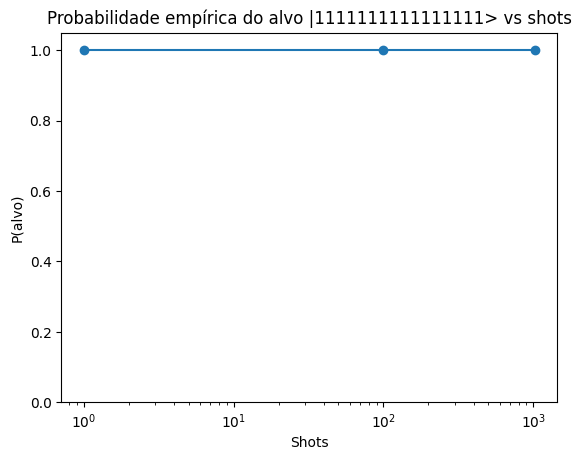

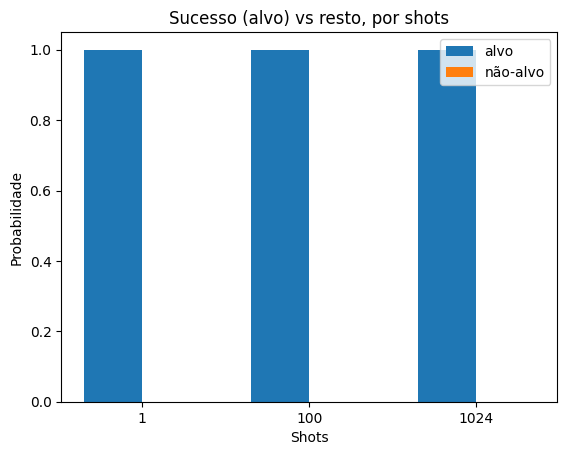

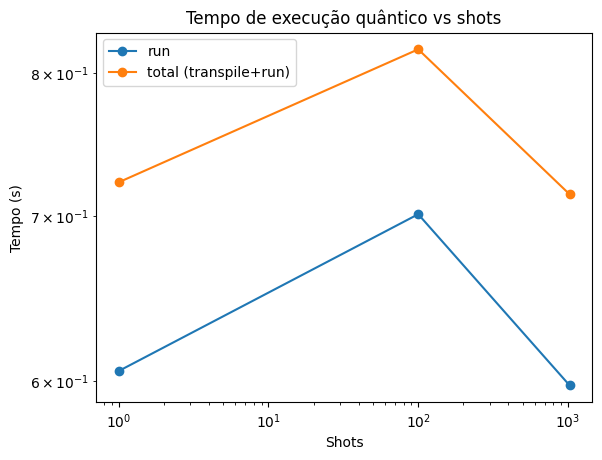

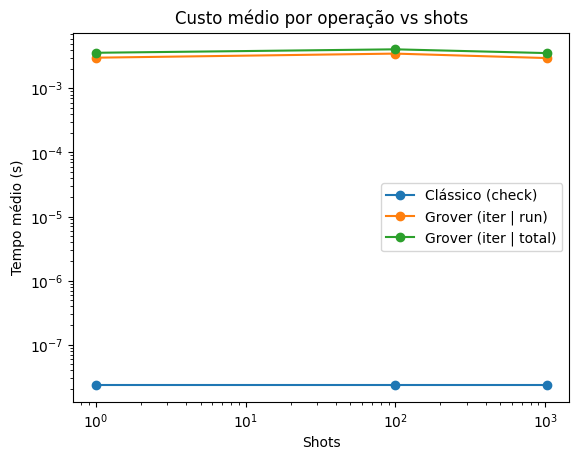

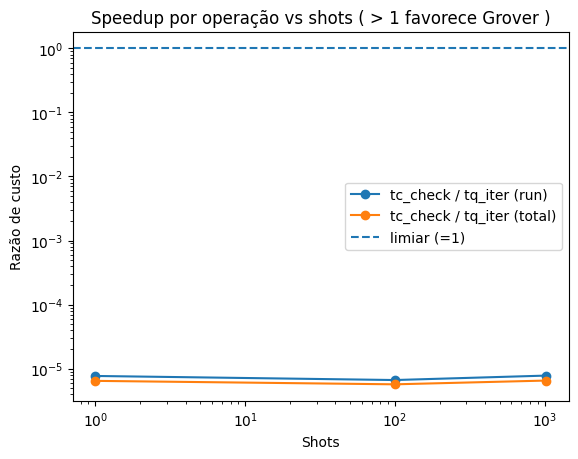

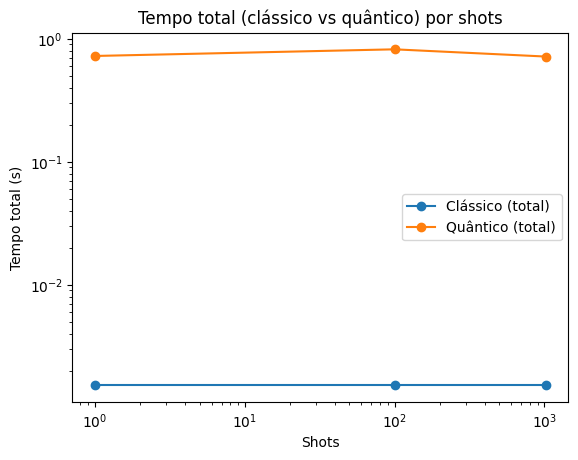


=== Resumo por shots ===
Alvo: |1111111111111111> | n=16 | k=201
Clássico: tc_check=2.32238769e-08 s | total=1.52200000e-03 s
- shots=   1 | top=|1111111111111111> 1/1 | P(alvo)=1.000000 | run=0.605710s | total=0.722508s
- shots= 100 | top=|1111111111111111> 100/100 | P(alvo)=1.000000 | run=0.701289s | total=0.818087s
- shots=1024 | top=|1111111111111111> 1024/1024 | P(alvo)=1.000000 | run=0.597687s | total=0.714485s


In [13]:
# ============================================================
# Gráficos COERENTES com o experimento por SHOTS
# (shots_list = [1, 100, 1024], results_by_shots[shots] preenchido)
#
# Pré-requisitos (já existentes no seu notebook):
# - shots_list (list[int])
# - results_by_shots (dict) com, para cada shots:
#     - "counts", "p_target", "t_run", "t_transpile", "t_total"
#     - (opcional) "full_probabilities" se você já calculou
# - target (str), n (int), k (int)
# - classic_result (dict) com:
#     - "execution_time", "time_per_check"
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
from qiskit.visualization import plot_histogram

# ----------------------------
# 0) Helpers
# ----------------------------
def counts_to_probabilities(counts: dict, shots: int) -> dict:
    """Normaliza counts para probabilidades (manual)."""
    return {state: c / shots for state, c in counts.items()}

def top_k_dict(d: dict, k_top: int = 16) -> dict:
    """Retorna um dict com os k_top maiores valores (por valor)."""
    return dict(sorted(d.items(), key=lambda kv: kv[1], reverse=True)[:k_top])

def build_top_states_probs_for_shots(shots: int, k_top: int = 16) -> tuple[dict, dict]:
    """Retorna (top_counts, top_probs) para um shots específico."""
    counts = results_by_shots[shots]["counts"]
    probs = counts_to_probabilities(counts, shots)
    # Para n grande (ex.: 16), plotar só os estados observados já é suficiente
    # e ainda limitamos por segurança.
    top_counts = top_k_dict(counts, k_top=k_top)
    top_probs = top_k_dict(probs, k_top=k_top)
    return top_counts, top_probs

# ----------------------------
# 1) Histogramas (counts e probabilities) por shots
#    (para n=16, só faz sentido mostrar TOP estados observados)
# ----------------------------
TOPK = 16  # ajuste se quiser mais/menos estados no histograma

for shots in shots_list:
    top_counts, top_probs = build_top_states_probs_for_shots(shots, k_top=TOPK)

    # Histograma de contagens (TOP estados)
    plot_histogram(
        top_counts,
        title=f"Histograma (contagens) — shots={shots} — TOP {TOPK} estados",
        figsize=(10, 4)
    )
    plt.show()

    # Histograma de probabilidades (TOP estados)
    plot_histogram(
        top_probs,
        title=f"Histograma (probabilidades) — shots={shots} — TOP {TOPK} estados",
        figsize=(10, 4)
    )
    plt.show()

# ----------------------------
# 2) Probabilidade do alvo vs shots
# ----------------------------
shots_sorted = sorted(shots_list)
p_target_list = [results_by_shots[s]["p_target"] for s in shots_sorted]

plt.figure()
plt.plot(shots_sorted, p_target_list, marker="o")
plt.title(f"Probabilidade empírica do alvo |{target}> vs shots")
plt.xlabel("Shots")
plt.ylabel("P(alvo)")
plt.xscale("log")
plt.ylim(0, 1.05)
plt.show()

# ----------------------------
# 3) Probabilidade de sucesso (alvo) vs não-alvo, por shots
# ----------------------------
p_non_target_list = [1.0 - results_by_shots[s]["p_target"] for s in shots_sorted]

x = np.arange(len(shots_sorted))
width = 0.35

plt.figure()
plt.bar(x - width/2, p_target_list, width, label="alvo")
plt.bar(x + width/2, p_non_target_list, width, label="não-alvo")
plt.title("Sucesso (alvo) vs resto, por shots")
plt.xticks(x, [str(s) for s in shots_sorted])
plt.xlabel("Shots")
plt.ylabel("Probabilidade")
plt.ylim(0, 1.05)
plt.legend()
plt.show()

# ----------------------------
# 4) Tempo (run) e tempo total (transpile + run) vs shots
# ----------------------------
t_run_list = [results_by_shots[s]["t_run"] for s in shots_sorted]
t_total_list = [results_by_shots[s]["t_total"] for s in shots_sorted]

plt.figure()
plt.plot(shots_sorted, t_run_list, marker="o", label="run")
plt.plot(shots_sorted, t_total_list, marker="o", label="total (transpile+run)")
plt.title("Tempo de execução quântico vs shots")
plt.xlabel("Shots")
plt.ylabel("Tempo (s)")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show()

# ----------------------------
# 5) Custo médio por operação: clássico vs quântico (por shots)
#    - clássico: tempo médio por verificação (constante)
#    - quântico: tempo médio por iteração de Grover (run/k e total/k)
# ----------------------------
tc_check = classic_result["time_per_check"]

tq_iter_run_list = [(results_by_shots[s]["t_run"] / k) if k > 0 else float("inf") for s in shots_sorted]
tq_iter_total_list = [(results_by_shots[s]["t_total"] / k) if k > 0 else float("inf") for s in shots_sorted]
tc_check_line = [tc_check for _ in shots_sorted]

plt.figure()
plt.plot(shots_sorted, tc_check_line, marker="o", label="Clássico (check)")
plt.plot(shots_sorted, tq_iter_run_list, marker="o", label="Grover (iter | run)")
plt.plot(shots_sorted, tq_iter_total_list, marker="o", label="Grover (iter | total)")
plt.title("Custo médio por operação vs shots")
plt.xlabel("Shots")
plt.ylabel("Tempo médio (s)")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show()

# ----------------------------
# 6) Speedup por operação (tc_check / tq_iter) vs shots
#    (valores > 1 favorecem Grover)
# ----------------------------
speedup_run_list = [(tc_check / v) if v > 0 else float("inf") for v in tq_iter_run_list]
speedup_total_list = [(tc_check / v) if v > 0 else float("inf") for v in tq_iter_total_list]

plt.figure()
plt.plot(shots_sorted, speedup_run_list, marker="o", label="tc_check / tq_iter (run)")
plt.plot(shots_sorted, speedup_total_list, marker="o", label="tc_check / tq_iter (total)")
plt.axhline(1.0, linestyle="--", label="limiar (=1)")
plt.title("Speedup por operação vs shots ( > 1 favorece Grover )")
plt.xlabel("Shots")
plt.ylabel("Razão de custo")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show()

# ----------------------------
# 7) Tempo total: clássico vs quântico (por shots)
#    - clássico: tempo total (constante)
#    - quântico: tempo total varia com shots (transpile+run)
# ----------------------------
t_total_classic = classic_result["execution_time"]
classic_total_line = [t_total_classic for _ in shots_sorted]

plt.figure()
plt.plot(shots_sorted, classic_total_line, marker="o", label="Clássico (total)")
plt.plot(shots_sorted, t_total_list, marker="o", label="Quântico (total)")
plt.title("Tempo total (clássico vs quântico) por shots")
plt.xlabel("Shots")
plt.ylabel("Tempo total (s)")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show()

# ----------------------------
# 8) Impressão resumida por shots (opcional)
# ----------------------------
print("\n=== Resumo por shots ===")
print(f"Alvo: |{target}> | n={n} | k={k}")
print(f"Clássico: tc_check={tc_check:.8e} s | total={t_total_classic:.8e} s")
for shots in shots_sorted:
    counts = results_by_shots[shots]["counts"]
    top_state, top_count = max(counts.items(), key=lambda kv: kv[1])
    p_target = results_by_shots[shots]["p_target"]
    t_run = results_by_shots[shots]["t_run"]
    t_total = results_by_shots[shots]["t_total"]
    print(
        f"- shots={shots:4d} | top=|{top_state}> {top_count}/{shots} "
        f"| P(alvo)={p_target:.6f} | run={t_run:.6f}s | total={t_total:.6f}s"
    )

## Discussão — Cenário 2 (n = 16, M = 1) com Variação do Número de Shots

Neste cenário, foi avaliado o desempenho do algoritmo de Grover com $n = 16$ qubits de busca, correspondendo a um espaço de busca de tamanho $N = 2^{16} = 65536$, considerando um único estado alvo $|1111111111111111\rangle$. O número ideal de iterações de Grover foi $k = 201$, em conformidade com a expressão teórica $k \approx \left\lfloor \frac{\pi}{4}\sqrt{N/M} \right\rfloor$. O experimento foi conduzido em um **ambiente de simulação sem ruído**, utilizando o Qiskit Aer Simulator em CPU, o que permite observar o comportamento ideal do algoritmo, sem efeitos de decoerência ou erros físicos.

### Impacto do Número de Shots na Fidelidade dos Resultados

Os resultados experimentais para $shots \in \{1, 100, 1024\}$ mostram um comportamento consistente e altamente estável. Em todos os casos, a probabilidade empírica do estado alvo foi $P(|1111111111111111\rangle) = 1.0$, com todas as medições colapsando exclusivamente no estado correto. Isso indica que, para este cenário específico, o circuito quântico amplificou completamente a amplitude do alvo, tornando-o determinístico no contexto da simulação ideal.

Do ponto de vista estatístico, esse resultado evidencia que, quando a probabilidade teórica do estado alvo é próxima de 1, o aumento do número de shots **não altera a fidelidade do resultado**, mas apenas reforça empiricamente a mesma conclusão. Em outras palavras, mesmo com $shots = 1$, o algoritmo já produz a resposta correta, e valores maiores de shots servem apenas para confirmar a distribuição de probabilidade prevista teoricamente.

### Análise de Desempenho Temporal e Custo Computacional

A análise temporal mostra que o tempo de execução do circuito quântico (run) permanece da ordem de $0.6$ a $0.7$ segundos, independentemente do número de shots. Essa observação é coerente com o funcionamento do simulador, no qual o custo dominante está associado à simulação do circuito quântico como um todo (em particular, à evolução do estado quântico), e não linearmente ao número de medições. O tempo de transpile, realizado uma única vez, também se mantém estável, em torno de $0.12$ segundos.

Quando se analisa o custo médio por iteração de Grover (oráculo + difusão), obtêm-se valores próximos de $3 \times 10^{-3}$ segundos, com pequenas variações entre diferentes valores de shots. Essas variações são atribuídas a flutuações naturais do ambiente de execução e à sobrecarga do simulador, não refletindo mudanças estruturais no algoritmo.

Em contraste, a busca clássica linear encontrou o alvo após $65536$ verificações, com um tempo total de aproximadamente $1.5 \times 10^{-3}$ segundos e um custo médio por verificação da ordem de $2.3 \times 10^{-8}$ segundos. Assim, mesmo para um espaço de busca relativamente grande ($N = 65536$), a implementação clássica permanece significativamente mais eficiente em termos de tempo absoluto neste ambiente computacional.

### Comparação Clássico vs. Quântico sob Diferentes Shots

A comparação direta do custo médio por operação revela que a razão $(tc\_check / tq\_iter)$ permanece muito menor que 1 para todos os valores de shots analisados. Isso indica que, **em ambiente simulado e sem ruído**, o overhead computacional associado à simulação quântica domina completamente o custo, impedindo que a vantagem assintótica teórica de Grover se manifeste em termos de tempo de execução real.

É importante destacar que o número de shots não altera essa conclusão: variar $shots$ afeta apenas a robustez estatística das medições, mas não reduz o custo médio por iteração quântica nem aproxima o desempenho do algoritmo quântico ao clássico neste contexto.

### Considerações Finais

Em síntese, os resultados do Cenário 2 demonstram que:
- O algoritmo de Grover funciona corretamente e com fidelidade máxima em ambiente ideal, independentemente do número de shots.
- O aumento do número de shots não impacta a probabilidade do alvo quando esta já é teoricamente igual a 1.
- Em simuladores clássicos sem ruído, o custo computacional da simulação quântica é substancialmente maior do que o da busca clássica linear, mesmo para valores relativamente grandes de $N$.
- A vantagem do algoritmo de Grover permanece **assintótica e conceitual**, tornando-se observável apenas em contextos onde o custo físico de operações quânticas reais substitua o overhead de simulação clássica.

Esses achados reforçam a importância de distinguir entre análise teórica de complexidade e avaliação prática em ambientes simulados, além de motivarem a investigação de cenários com ruído controlado ou hardware quântico real, onde a dinâmica de custos pode ser substancialmente diferente.